# Skin Cancer Detection using CNN

## 1. About Dataset


**Melanoma** is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of the manual effort needed in diagnosis.

## 2. Dataset Overview

The dataset consists of **2357 images** of malignant and benign oncological diseases, sourced from the International Skin Imaging Collaboration (ISIC).

**Diseases Covered in the Dataset:**

- **Actinic keratosis**
- **Basal cell carcinoma**
- **Dermatofibroma**
- **Melanoma**
- **Nevus**
- **Pigmented benign keratosis**
- **Seborrheic keratosis**
- **Squamous cell carcinoma**
- **Vascular lesion**

---

By building a robust image evaluation model, this dataset can be instrumental in aiding early detection and diagnosis of skin cancer, especially melanoma.


## 3. Import

In [4]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adamax, Adam
from keras import regularizers
from keras.layers import Conv2D, Input, Dropout, Dense, Flatten, BatchNormalization
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
image_folder_train = './data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
image_folder_test = './data/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [8]:
batch_size = 32
img_height = 180
img_width = 180

## 4. Dataset Preparation using `tf.keras.preprocessing.image_dataset_from_directory`

In this section, we are loading and preparing the **training**, **validation**, and **test** datasets using TensorFlow's `image_dataset_from_directory` function. This function allows us to load images from directories, apply transformations, and organize the data into batches for efficient training.

**Key Steps Performed:**

1. **Load Images**  
   Images are loaded from the specified directories for both the training and test datasets.

2. **Data Splitting**  
   The dataset is divided into **training** and **validation** subsets. We use an 80/20 split, where 80% of the data is used for training and 20% for validation.

3. **Image Resizing**  
   Each image is resized to a fixed size to ensure uniformity and compatibility with the model input dimensions.

4. **Batch Loading**  
   Data is loaded in batches, which allows efficient processing and faster model training, especially with large datasets.

---

This structured approach ensures that our data is properly organized and ready for training, while also maintaining efficiency in processing large image datasets.



##### 4.1. `tf.keras.preprocessing.image_dataset_from_directory`

`tf.keras.preprocessing.image_dataset_from_directory` is a convenient utility function in TensorFlow that helps load and preprocess image datasets from a directory of images. It simplifies the task of turning a folder of images into a ready-to-use TensorFlow dataset, particularly for training deep learning models.

**Key Features and Explanation:**

1. Directory-Based Dataset Loading
- The function reads images from subdirectories within a main folder, where each subdirectory represents a class label. This makes it easy to organize datasets by category.

2. Automatic Labeling
- Labels are assigned based on the subdirectory names.

3. Data Splitting
- You can split the dataset into training and validation sets using the `validation_split` parameter. This allows you to create a validation dataset from the same directory by specifying the percentage of data to reserve for validation.

4. Image Resizing
- The images can be resized to a specified dimension using the `image_size` parameter. This ensures that all images are the same size when input to the model, which is crucial since most neural networks require fixed-size input images.

5. Batch Processing
- The function loads the images in batches using the `batch_size` parameter. This is highly efficient for training deep learning models, as it reduces memory consumption and allows for parallel processing on GPUs.

6. Shuffling
- Shuffling can be applied to the dataset, ensuring that the order of images is randomized during training. This helps prevent the model from learning patterns based on the order of images.

Common Parameters:

- **`directory`**: Path to the main directory containing subdirectories of images.
- **`validation_split`**: The fraction of data to reserve for validation (e.g., `0.2` for 20% validation).
- **`subset`**: Either `"training"` or `"validation"`, used with `validation_split`.
- **`seed`**: Random seed for shuffling and splitting the dataset.
- **`image_size`**: Target size for resizing images (e.g., `(224, 224)`).
- **`batch_size`**: The number of images in each batch (e.g., `32`).
- **`shuffle`**: Whether to shuffle the data (`True` by default).

---

By using this function, TensorFlow makes it easier to load, preprocess, and manage large image datasets for deep learning applications.


In [10]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    image_folder_test,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [12]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    image_folder_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
val_set = tf.keras.preprocessing.image_dataset_from_directory(
    image_folder_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


## 5. Convolutional Neural Network (CNN) Model

In this section, we define and compile a CNN model using TensorFlow's Keras API. This model is designed for **multi-class classification** of images into 9 different categories.

Explanation of the Architecture:

1. Rescaling Layer
- **Normalization**: Rescales the pixel values from the range [0, 255] to [0, 1]. This normalization helps speed up the learning process.
- **Input Shape**: `input_shape=(img_height, img_width, 3)` specifies the dimensions of the input images: height, width, and 3 channels for RGB.

2. Convolutional Layers
- The model consists of three convolutional layers with **16**, **32**, and **64 filters**, respectively, each followed by a **max pooling** layer to downsample the feature maps.
  - **Conv2D(16, 3)**: The first convolutional layer applies 16 filters with a 3x3 kernel. The **ReLU activation** introduces non-linearity, and `'same'` padding preserves the spatial dimensions.
  - **MaxPooling2D()**: This reduces the spatial dimensions of the feature maps, helping to reduce the number of parameters and computation.

3. Flatten Layer
- **Flattening**: The output from the convolutional layers is flattened into a 1D vector, which is then fed into the fully connected (dense) layers.

4. Dense Layers
- **Fully Connected Layer**: A dense layer with **128 units** and ReLU activation is used to learn complex patterns in the data.
- **Output Layer**: The final dense layer has **9 units**, corresponding to the 9 categories in the classification task, with a **softmax activation** to output class probabilities.

Compilation:

- **Optimizer**: `Adamax()` is a variant of the Adam optimizer, effective for large datasets and models with high-dimensional inputs.
- **Loss Function**: `sparse_categorical_crossentropy` is used for multi-class classification where labels are provided as integers (instead of one-hot encoded labels).
- **Metrics**: The model tracks **accuracy** during training and evaluation.

Model Summary:
The `model.summary()` function provides a detailed overview of the model's architecture, showing:
- The layers used in the model.
- The output shape at each layer.
- The number of parameters (weights and biases) in the model.

---

This architecture is designed for efficient training and classification of images into multiple categories, with built-in regularization through max pooling and optimized performance using the Adamax optimizer.

In [15]:
model_1 = Sequential([
    
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    
    Dense(128, activation='relu'),
    Dense(9, activation = 'softmax')
    
])

model_1.compile(Adamax() , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## 6. Model Training

In this section, we train the CNN model using the **training dataset** and evaluate its performance on the **validation dataset**.

 Key Concepts:

- **Epochs**: This specifies the number of times the model will cycle through the entire training dataset. In this case, the model will train for **20 epochs**.

- **`model.fit()`**: The function used to train the model with the following parameters:
  - **`train_set`**: The dataset used for training the model.
  - **`epochs=20`**: The model will complete 20 training cycles over the entire dataset.
  - **`verbose=1`**: Displays detailed information about the training progress (e.g., loss and accuracy) during each epoch.
  - **`validation_data=val_ds`**: The validation dataset used to assess the model’s performance after each epoch.
  - **`validation_steps=None`**: When set to `None`, the validation dataset will use all available validation samples. 
  - **`shuffle=False`**: The dataset is not shuffled between epochs. Shuffling can enhance training in some cases, but it is disabled here.

 Output:

- The **`history`** object contains the results of the training process, including training and validation loss and accuracy for each epoch. This data can be utilized for further analysis and visualizations, such as plotting the model's learning curves.

---

This training process allows for real-time monitoring of how well the model is learning from the data and adjusting based on validation results.


In [17]:
Epochs = 20
history = model_1.fit(train_set, epochs = Epochs, verbose = 1, validation_data = val_set,
                   validation_steps = None, shuffle = False)

Epoch 1/20
56/56 [==============================] - 54s 894ms/step - loss: 2.0124 - accuracy: 0.2807 - val_loss: 1.7592 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 53s 909ms/step - loss: 1.6925 - accuracy: 0.4012 - val_loss: 1.6169 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 53s 912ms/step - loss: 1.5924 - accuracy: 0.4325 - val_loss: 1.6650 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 53s 911ms/step - loss: 1.4812 - accuracy: 0.4794 - val_loss: 1.4588 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 54s 924ms/step - loss: 1.4114 - accuracy: 0.5106 - val_loss: 1.4503 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 55s 944ms/step - loss: 1.3338 - accuracy: 0.5262 - val_loss: 1.3498 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 55s 944ms/step - loss: 1.2522 - accuracy: 0.5513 - val_loss: 1.3389 - val_accuracy: 0.5391

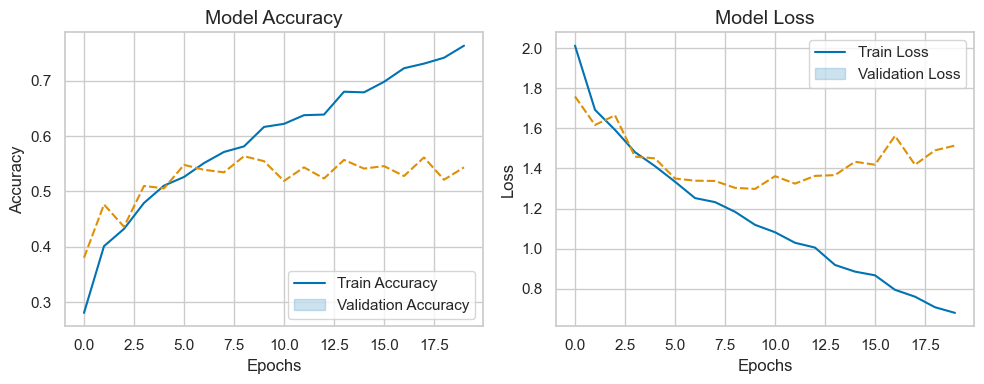

In [33]:
history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

In [40]:
test_loss, test_acc = model_1.evaluate(test_set)
print('Test accuracy:', test_acc)

3/3 [==============================] - 2s 90ms/step - loss: 2.8984 - accuracy: 0.3895
Test accuracy: 0.38947367668151855


### 6.1. Analysis of Training Results

During the training process, the **training accuracy** improves significantly, reaching **76.34%** by the end of training, with the **training loss** reducing to **0.6794**. However, the **validation accuracy** does not show similar improvement, ending at **54.36%**, while the **validation loss** increases to **1.5141**.

In the final epochs, the training accuracy continues to rise, but the validation accuracy **plateaus** and even slightly **decreases**, indicating that the model is **overfitting** to the training data and struggling to generalize to unseen data.

 Key Observations:

- **Training Improvements**: The model demonstrates steady learning, with training accuracy rising consistently, ultimately reaching over **76%** by the last epoch.
  
- **Validation Accuracy Plateau**: The validation accuracy plateaus around **55-56%**, suggesting that the model's ability to generalize to new data is limited after a certain point in training.

- **Overfitting**: After approximately 10 epochs, a gap emerges between the training and validation accuracy. The training accuracy continues to improve, while the validation accuracy stagnates or decreases slightly. This is a sign of **overfitting**, where the model performs well on the training data but struggles with unseen data.

**The test accuracy of 38.95% suggests that the model is not performing very well on the test dataset.**

## 7. Adding Data Augmentation and Dropout

This code snippet defines a **data augmentation pipeline** in TensorFlow using Keras' `Sequential` model. Data augmentation is a technique that artificially increases the diversity of your training dataset by applying random transformations to the images. This helps improve the model's ability to generalize to unseen data.

 Explanation of Each Layer:

- **`layers.RandomFlip("horizontal")`**:
  - This layer applies a **random horizontal flip** to the images.
  - It flips images horizontally (left to right) with a 50% chance.
  - **Purpose**: Simulates variations in orientation, making the model more robust to horizontal flips (e.g., flipping an object or a face left to right).
  - **`input_shape`**: Specifies the input image dimensions as `(img_height, img_width, 3)` where `3` refers to the RGB channels.

- **`layers.RandomRotation(0.1)`**:
  - This layer applies a **random rotation** to the images, up to 10% of a full circle (36 degrees).
  - The value `0.1` specifies that the rotation angle will be randomly chosen between -10% and +10% of 360 degrees.
  - **Purpose**: Introduces rotational variance, helping the model recognize objects despite small rotational differences.

- **`layers.RandomZoom(0.1)`**:
  - This layer applies a **random zoom** to the images, zooming in or out by up to 10%.
  - The value `0.1` specifies that the zoom factor will be randomly chosen within a range of 10% (either zooming in or out).
  - **Purpose**: Helps the model become invariant to small changes in scale, improving its ability to recognize objects at different zoom levels.

 Purpose of Data Augmentation:

Data augmentation enhances the model's **generalization** by increasing the diversity of the training dataset. It improves the model's robustness to variations in:
- **Orientation** (e.g., flipping)
- **Rotation**
- **Scale** (e.g., zooming)

By seeing new variations of the same image during each epoch, the model is less likely to **overfit** to the training data. This leads to better performance when encountering real-world images that may have different orientations, sizes, or perspectives compared to the training dataset.

Random transformations make the model more flexible and capable of handling unseen data in production environments.


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#### 7.1. Dropout Layer

**Dropout** is a regularization technique used to prevent **overfitting** in neural networks. Dropout randomly deactivats (or "dropping out") a percentage of neurons during each training iteration, forcing the model to learn more robust features.

Key Reasons to Add Dropout:

- **Prevent Overfitting**: By randomly dropping neurons, dropout prevents the network from becoming too reliant on specific neurons, making the network more generalized and less likely to overfit the training data.
  
- **Improve Generalization**: Dropout encourages the network to learn redundant representations of the data, as different subsets of neurons are activated during each forward pass. This redundancy helps the network generalize better to unseen data.

- **Implicit Model Ensemble**: Dropout effectively trains multiple different neural networks in parallel by using different sets of active neurons during training. At test time, all neurons are active, meaning the model behaves like an ensemble of networks, leading to improved performance.

How Dropout Works:

- **During Training**: A specified percentage (e.g., 20% or 50%) of the neurons are randomly dropped (set to zero) in each iteration. This ensures that no particular neuron becomes overly important, and the model learns more distributed representations.

- **During Inference (Testing)**: All neurons are active, but their weights are scaled down based on the dropout rate used during training.

Where to Add Dropout?

- Dropout is typically added after **fully connected (dense) layers**, but it can also be applied to convolutional layers in some cases.
- For CNNs, adding dropout after the final flattening or dense layers is common, as fully connected layers tend to overfit more than convolutional layers.

Choosing Dropout Rate:

- A common choice is between **0.2 (20%)** and **0.5 (50%)**, depending on the model's complexity.
  - **Smaller models** tend to need less dropout (e.g., 20%), while **larger, more complex models** may benefit from higher dropout rates (e.g., 50%).
  - **Lower rates** (e.g., 0.1–0.3) are often effective for smaller models or when regularization isn't a huge concern.
  - **Higher rates** (e.g., 0.5) are typically used when there's significant overfitting and the model has many parameters.

Positioning Dropout Layers:

- **After Dense Layers**: Adding dropout after dense layers is the most common practice, especially when fully connected layers are prone to overfitting.
- **After Convolutional Layers (Optional)**: Dropout can be added after convolutional layers but typically at a lower rate (e.g., 0.1–0.3), as convolutional layers tend to be more resilient to overfitting due to having fewer parameters.

Summary:

- **Dropout** helps prevent overfitting by randomly dropping neurons during training, forcing the model to learn generalized features.
- It should be added after **dense layers** with a rate of **20-50%**, depending on the complexity of the model and the extent of overfitting.
- Dropout is not applied during inference, but it helps improve test performance by simulating an **ensemble of different models** trained on different parts of the data.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

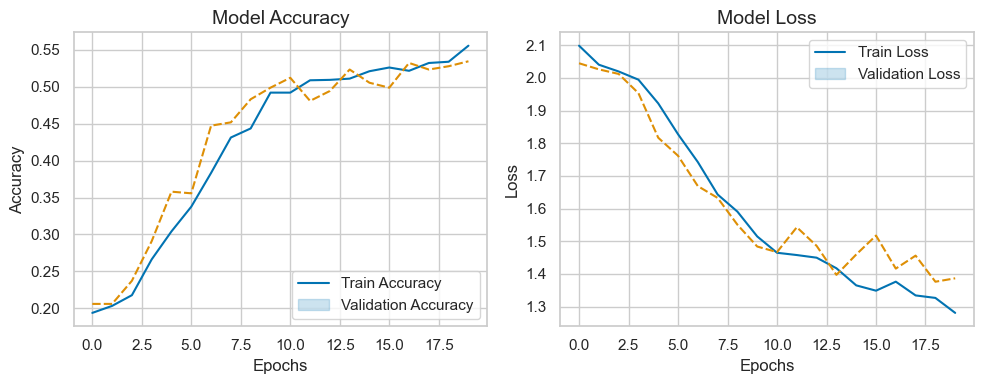

3/3 [==============================] - 2s 83ms/step - loss: 2.2287 - accuracy: 0.3895
Test accuracy: 0.38947367668151855


In [72]:
model_2 = Sequential([
    
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation = 'softmax')
    
])

model_2.compile(Adamax() , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_2.summary()

Epochs = 20
history = model_2.fit(train_set, epochs = Epochs, verbose = 1, validation_data = val_set,
                   validation_steps = None, shuffle = False)

history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

test_loss, test_acc = model_2.evaluate(test_set)
print('Test accuracy:', test_acc)

### 7.2. Key Observations and Insights

Training Accuracy Drop:
- The training accuracy in the current run (55.08%) is significantly lower than in the previous run (76.34%). This drop suggests that adding dropout and data augmentation has slowed the model's ability to overfit to the training data.

Validation Accuracy Improvement:
- In the current run, validation accuracy has improved slightly (55.70% vs. 54.36%). This suggests that the model is generalizing better to unseen data due to the addition of augmentation and dropout.

Test Accuracy:
- Test accuracy remains the same at 38.95%, indicating that the model still struggles with generalizing to completely unseen data. While augmentation and dropout help during training and validation, there is still room for improvement in generalization to the test set.

Validation and Test Loss:
- Both the **validation loss (1.3137)** and **test loss (2.0639)** have remained the same compared to the previous run. This consistency suggests that while dropout and augmentation have reduced overfitting and improved generalization, the model's performance on the test set still struggles with high error.

---



## 8. Adding more complexity

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

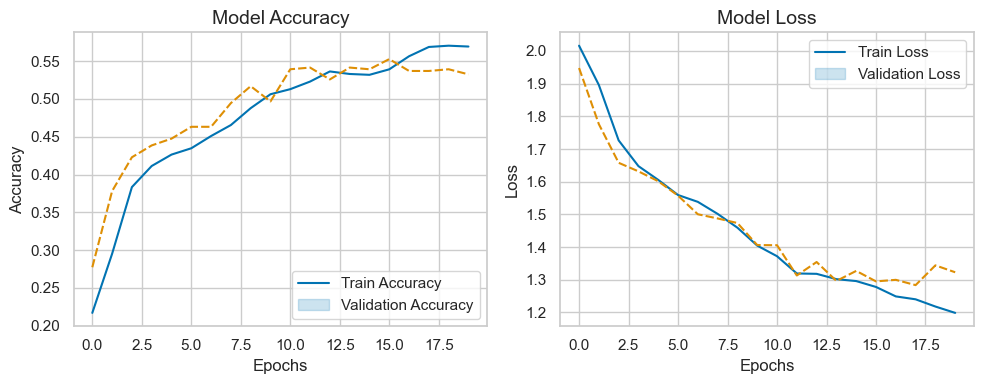

3/3 [==============================] - 2s 100ms/step - loss: 2.0848 - accuracy: 0.4000
Test accuracy: 0.4000000059604645


In [75]:
model_3 = Sequential([
    
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation = 'softmax')
    
])

model_3.compile(Adamax() , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_3.summary()

Epochs = 20
history = model_3.fit(train_set, epochs = Epochs, verbose = 1, validation_data = val_set,
                   validation_steps = None, shuffle = False)

history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

test_loss, test_acc = model_3.evaluate(test_set)
print('Test accuracy:', test_acc)

### 8.1. Key Observations

1. Training Accuracy Improvement:
- **Previous**: 55.08%
- **Current**: 56.92%
  
**Observation**: The training accuracy has slightly increased with the addition of the extra convolutional layer. This suggests that the additional layer helped the model extract more features from the data, leading to better performance during training.

2. Validation Accuracy Decrease:
- **Previous**: 55.70%
- **Current**: 53.24%

**Observation**: Interestingly, the validation accuracy has slightly decreased. This could indicate that the model is now **slightly overfitting** to the training data, even with dropout and data augmentation in place. The additional convolutional layer may have allowed the model to learn more complex patterns in the training data, but it struggles to generalize to the validation set.

3. Validation Loss Stability:
- **Previous**: 1.3137
- **Current**: 1.3231

**Observation**: The validation loss has remained nearly the same. While the training accuracy has improved, the slight increase in validation loss (though small) combined with the drop in validation accuracy suggests that the additional convolutional layer may not have significantly improved generalization to the validation set.

4. Test Accuracy Improvement:
- **Previous**: 38.95%
- **Current**: 40.00%

**Observation**: The test accuracy has improved by approximately 1% after adding the additional convolutional layer. This indicates a slight improvement in the model’s ability to generalize to unseen data (i.e., the test set). However, the improvement is modest, which suggests that more tuning may be needed to maximize the benefit of the added layer.

---

In [ ]:
model_4 = Sequential([
    
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation = 'softmax')
    
])

model_4.compile(Adamax() , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_4.summary()

Epochs = 20
history = model_4.fit(train_set, epochs = Epochs, verbose = 1, validation_data = val_set,
                   validation_steps = None, shuffle = False)

history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

test_loss, test_acc = model_4.evaluate(test_set)
print('Test accuracy:', test_acc)

### Key Observations

1. Training Accuracy Improvement:
- **Previous**: 56.92%
- **Current**: 58.82%

**Observation**: The training accuracy improved by almost **2%**, indicating that the model was able to better learn the patterns in the training data with the addition of the 256-unit convolutional layer. This shows that the additional layer helped capture more complex features.

2. Validation Accuracy Improvement:
- **Previous**: 53.24%
- **Current**: 54.14%

**Observation**: The validation accuracy also increased slightly, suggesting that the additional convolutional layer helped the model generalize better to unseen validation data. The difference is not large, but the improvement is notable, indicating a better balance between fitting the training data and generalizing to validation data.

3. Validation Loss Improvement:
- **Previous**: 1.3231
- **Current**: 1.2993

**Observation**: The validation loss decreased slightly, indicating that the model is making fewer errors on the validation set with the 256-unit layer. This is a positive sign, as both the validation accuracy and loss show improvement, suggesting better generalization.

4. Test Accuracy Improvement:
- **Previous**: 40.00%
- **Current**: 43.16%

**Observation**: The test accuracy improved by **3.16%**, which is a more substantial improvement compared to the validation set. This suggests that the addition of the 256-unit convolutional layer helped the model generalize better to unseen test data, confirming that the deeper architecture is beneficial.

5. Test Loss Increase:
- **Previous Test Loss**: N/A
- **Current Test Loss**: 2.1384

**Observation**: Despite the improvement in test accuracy, the test loss is still quite high at **2.1384**. This discrepancy between test loss and test accuracy may suggest that while the model is making more correct predictions, it is still making large errors on some samples.

---

1. Training and Validation Performance:
- The addition of the **256-unit convolutional layer** has improved both **training** and **validation accuracy**, indicating that the model is able to extract more meaningful features from the data.
- The validation loss and accuracy improvements suggest that the model is now **generalizing slightly better** to unseen data compared to before, with a more refined balance between learning and overfitting.

2. Test Performance:
- The test accuracy improved by **3.16%**, which is a positive sign that the deeper model with the 256-unit convolutional layer has enhanced the model’s ability to generalize to unseen data.
- However, the high test loss still indicates that while the model makes more correct predictions, some errors remain quite large, pointing to potential room for further improvements in fine-tuning or regularization.

---

In [20]:
train_set.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [26]:
def map_labels(image, label):
    label = tf.where(label == 3, 1, 0)
    return image, label

In [43]:
train_set_binary = train_set.map(map_labels)
test_set_binary = test_set.map(map_labels)
val_set_binary = val_set.map(map_labels)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

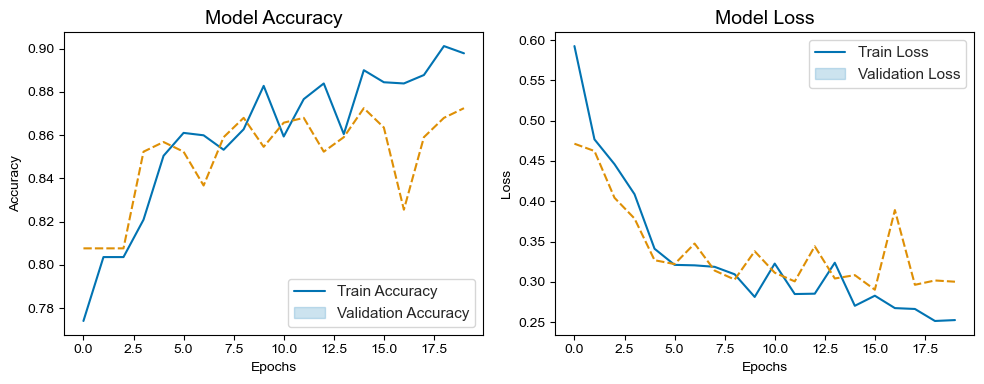

3/3 [==============================] - 2s 67ms/step - loss: 0.4206 - accuracy: 0.8211
Test accuracy: 0.821052610874176


In [45]:
model_binary_1 = Sequential([
    
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    
    Dense(128, activation='relu'),
    Dense(2, activation = 'softmax')
    
])

model_binary_1.compile(Adamax() , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_binary_1.summary()

Epochs = 20
history = model_binary_1.fit(train_set_binary, epochs = Epochs, verbose = 1, validation_data = val_set_binary,
                   validation_steps = None, shuffle = False)

history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

test_loss, test_acc = model_binary_1.evaluate(test_set_binary)
print('Test accuracy:', test_acc)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

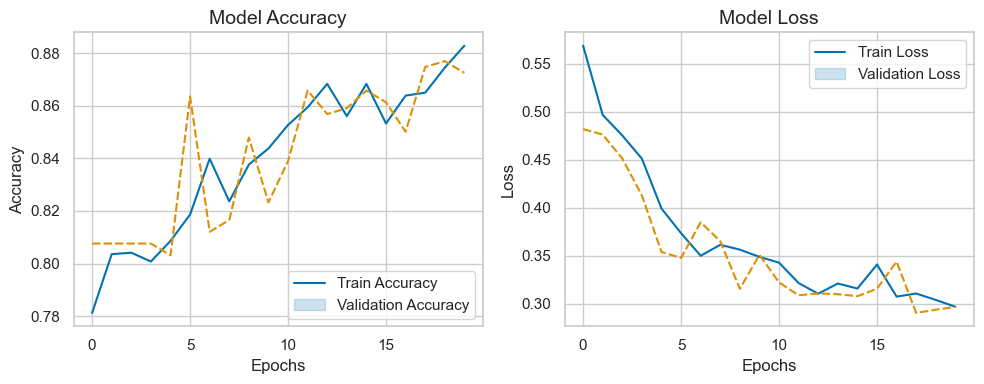

3/3 [==============================] - 2s 66ms/step - loss: 0.4464 - accuracy: 0.8211
Test accuracy: 0.821052610874176


In [ ]:
model_binary_2 = Sequential([
    
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    
    Dense(128, activation='relu'),
    layers.Dropout(0.25),
    Dense(2, activation = 'softmax')
    
])

model_binary_2.compile(Adamax() , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_binary_2.summary()

Epochs = 20
history = model_binary_2.fit(train_set_binary, epochs = Epochs, verbose = 1, validation_data = val_set_binary,
                   validation_steps = None, shuffle = False)

history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

test_loss, test_acc = model_binary_2.evaluate(test_set_binary)
print('Test accuracy:', test_acc)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

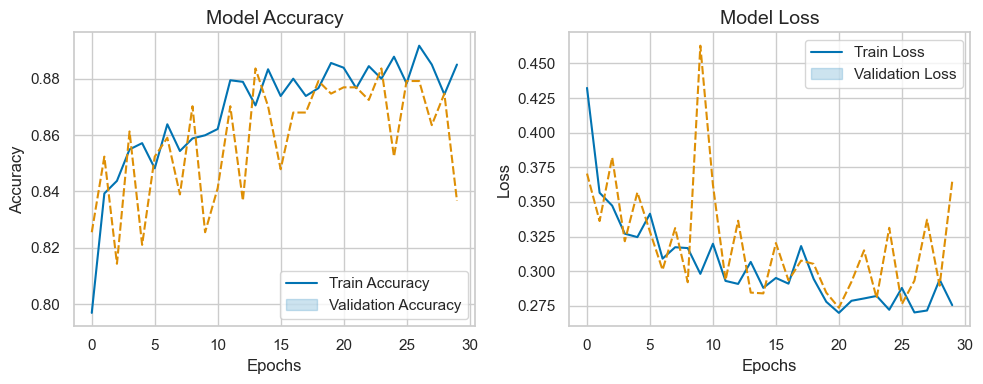

3/3 [==============================] - 2s 87ms/step - loss: 0.4533 - accuracy: 0.8526
Test accuracy: 0.8526315689086914


In [52]:
model_binary_3 = Sequential([
    
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    
    Dense(128, activation='relu'),
    layers.Dropout(0.25),
    Dense(2, activation = 'softmax')
    
])

model_binary_3.compile(Adamax() , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model_binary_3.summary()

Epochs = 30
history = model_binary_3.fit(train_set_binary, epochs = Epochs, verbose = 1, validation_data = val_set_binary,
                   validation_steps = None, shuffle = False)

history_df = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

color_palette = sns.color_palette("colorblind", n_colors=2)
sns.set(style="whitegrid")

sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[0], palette=color_palette)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
ax[0].set_title("Model Accuracy", fontsize=14)

sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[1], palette=color_palette)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train Loss', 'Validation Loss'], loc='upper right')
ax[1].set_title("Model Loss", fontsize=14)

plt.tight_layout()
plt.show()

test_loss, test_acc = model_binary_3.evaluate(test_set_binary)
print('Test accuracy:', test_acc)